# Project -- Recommendations with IBM


## Introduction
> Being recommended by various types of products or services when we browse on the social media or just would like to reserve a room in Airbnb becomes an usual scenario as a part of surfing the Internet. While sometimes it's annoying when advertisments are frequently jumping out, it's also provide users novelty and serendipity when the recommendations spot on their requests. The mechanism behind the recommendation engines is explored, and the interactions between users and articles is also analyzed in this project. The datasets are provided by Udacity and include two parts: <br>

> 1. Interaction of users and articles: The dataset includes article id, title of article, and email <br>
> 2. Information of articles: It contains information such as id, descriptions, status, full name of articles <br> 



## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Conclusion](#conclusions)


In [1]:
# Necessary packages
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import project_tests as t
import pickle

# nltk
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import linear_kernel
#from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

# Better display for Jupyter notebooks
import warnings
%matplotlib inline
%config InlineBachend.figure_format = 'retina'
warnings.simplefilter("ignore")

# Load the dataset

df = pd.read_csv('/Users/johnma/Desktop/Udacity_Data Scientist/Project folder/Project 3_Recommendation Engines/Data/user-item-interactions.csv')
df_content = pd.read_csv('/Users/johnma/Desktop/Udacity_Data Scientist/Project folder/Project 3_Recommendation Engines/Data/articles_community.csv')

del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

[nltk_data] Downloading package punkt to /Users/johnma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/johnma/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.tail(5)

,doc_body,doc_description,doc_full_name,doc_status,article_id
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049
1055,Homepage Follow Sign in / Sign up Homepage * H...,Once you get used to developing in a Notebook ...,"Jupyter Notebooks with Scala, Python, or R Ker...",Live,1050


In [3]:
# Overview of df
print (df.info())
print ('-----------------')
print ('Rows with missing items are listed below')
print ('-----------------')
print (df.isnull().sum())
print ('-----------------')
print ('Duplicated rows are listed below')
print ('-----------------')
print (df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45993 non-null  float64
 1   title       45993 non-null  object 
 2   email       45976 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB
None
-----------------
Rows with missing items are listed below
-----------------
article_id     0
title          0
email         17
dtype: int64
-----------------
Duplicated rows are listed below
-----------------
12311


In [4]:
# Overview of df_content
print (df_content.info())
print ('-----------------')
print ('Rows with missing items are listed below')
print ('-----------------')
print (df_content.isnull().sum())
print ('-----------------')
print ('Duplicated rows are listed below')
print ('-----------------')
print (df_content.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB
None
-----------------
Rows with missing items are listed below
-----------------
doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64
-----------------
Duplicated rows are listed below
-----------------
0


### Overview of Data 

> 1. dtype of 'article_id' is flt
> 2. In the content of email & doc_body & doc_description, few rows with missing values are found
> 3. There are 12311 duplicated rows in df 

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [5]:
# Since each email address represents a unique user,
# groupby function is used to demonstrate the interaction between user and articles
data = df.groupby('email')['article_id'].count()
data

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
                                            ..
ffc6cfa435937ca0df967b44e9178439d04e3537     2
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     4
ffe3d0543c9046d35c2ee3724ea9d774dff98a32    32
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81    10
fffb93a166547448a0ff0232558118d59395fecd    13
Name: article_id, Length: 5148, dtype: int64

In [6]:
data.value_counts().iloc[:10]

1     1416
2      694
3      485
4      351
5      277
6      228
7      182
8      156
10     124
9      115
Name: article_id, dtype: int64

The median number of user article is 3.0
The maximum number of user-article interactions is 364


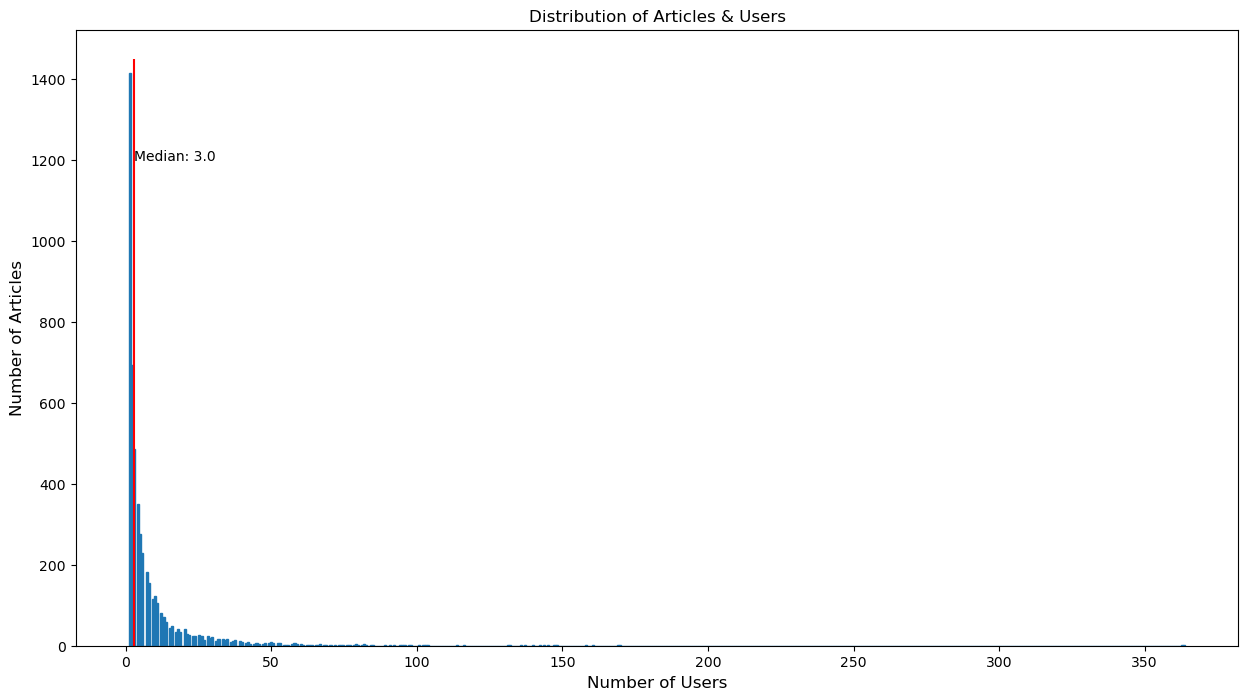

In [7]:
## Fill in the median and maximum number of user_article interactios below

# 50% of individuals interact with "3" number of articles or fewer.
median_val = data.median()
print ('The median number of user article is', median_val)

# The maximum number of user-article interactions by any 1 user is 364.
max_views_by_user = data.max()
print ('The maximum number of user-article interactions is', max_views_by_user)

# plot the distribution of articles & users
plt.figure(figsize=(15,8))
base_color = sb.color_palette()[0]
plt.hist(data, bins = 500, ec=base_color)
plt.vlines(x=median_val, ymin=0, ymax=1450, color='red')
plt.xlabel('Number of Users', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.title('Distribution of Articles & Users')
plt.annotate(xy=(median_val, 1200), text=f'Median: {median_val}')
#plt.annotate(xy=(median, 2500), s=f'Median: {median}');
plt.savefig('Distribution of Article & user.png')
plt.show();

**The distriubion of articles and users is visualized as above. Clearly, the distriubtion is quite right-skewed, and the frequecies of the top 3 popular articles are 1416, 694, and 485 times respectively. Also, 50% of indivisuals interact with 3 articles or fewer while the maximum number of user-article interaction by any one user is 364 times**


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [8]:
# Find and explore duplicate articles -- 5 duplicates are found based on article_id
df_content.duplicated(subset='article_id').sum()

5

In [9]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)

# Check whether the duplicates are removed
df_content.duplicated(subset='article_id').sum()

0

**5 duplicates are found, and the duplicated rows are also removed.**

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:
# The number of unique articles that have at least one interaction
unique_articles = len (pd.crosstab(df['email'], df['article_id']).sum())

# The number of unique articles on the IBM platform
total_articles = df_content['article_id'].nunique() 

# The number of unique users
unique_users = df['email'].nunique() 

# The number of user-article interactions
user_article_interactions = df.shape[0]

In [11]:
print ('a. The number of unique articles that have an interaction with a user is', unique_articles)
print ('b. The number of unique articles in the dataset is', total_articles)
print ('c. The number of unique users in the dataset is', unique_users)
print ('d. The number of user-article interactions in the dataset is', user_article_interactions)

a. The number of unique articles that have an interaction with a user is 714
b. The number of unique articles in the dataset is 1051
c. The number of unique users in the dataset is 5148
d. The number of user-article interactions in the dataset is 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [12]:
# Get the top 10 reivewed article id with number of views
df.groupby('article_id')['email'].count().sort_values(ascending=False).iloc[:10]

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
Name: email, dtype: int64

In [13]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str (df.groupby('article_id')['email'].count().sort_values(ascending=False).index[:1][0])

#The most viewed article in the dataset was viewed how many times?
max_views = df.groupby('article_id')['email'].count().sort_values(ascending=False).values[:1][0]

print ('The ID of the most viewd article is', most_viewed_article_id)
print ('The max number of viewed is', max_views)

The ID of the most viewd article is 1429.0
The max number of viewed is 937


In [14]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [15]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>


`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [16]:
df.groupby('article_id')['title'].count().sort_values(ascending=False).iloc[:10]

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
Name: title, dtype: int64

In [17]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    
    top_articles = df.groupby('title')['article_id'].count().sort_values(ascending=False).index[:n]
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    
    top_articles = df.groupby('article_id')['title'].count().sort_values(ascending=False).index[:n]
 
    return top_articles # Return the top article ids

In [18]:
print(get_top_articles(10))
print(get_top_article_ids(10))

Index(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'],
      dtype='object', name='title')
Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0],
             dtype='float64', name='article_id')


In [19]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [20]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Use function of crosstab to create matrix
    user_item = pd.crosstab(df['user_id'], df['article_id'])
    
    # Assign a value of 1 to all the elements in the user-item matrix that satisfy the condition user_item > 0
    user_item[user_item > 0] = 1
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [21]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar). Use the tests to test your function.

In [22]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user by using dot function
    dot_prod_user = user_item.dot(user_item.loc[user_id])

    # sort by similarity
    similarities = dot_prod_user.sort_values(ascending = False)

    # create list of just the user ids
    most_similar_users = list (similarities.index)
    
    # remove the own user's id
    most_similar_users.remove(user_id)
    
 
    return most_similar_users # return a list of the users in order from most to least similar
        

In [23]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Complete the functions below to return the articles you would recommend to each user. 

In [24]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    
    df.article_id = df.article_id.astype(str) # Convert dtype of article_id into str
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    
    user = user_item.loc[user_id]
    article_ids = user [user == 1].index.tolist() # List for user series mapping with user_item as 1
    article_ids = [str (article_id) for article_id in article_ids] # Convert article_ids into str
    
    article_names = get_article_names(article_ids, df)
    
 
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    similar_user_id = find_similar_users(user_id)
    user_article_id = get_user_articles(similar_user_id)[0]
    recs = []
    for user in similar_user_id:
        user_article_id = get_user_articles(user)[0] # get the list of article ids and names of each user
        for article_id in rec_article_id:
            if (article_id in rec_ariticle_id) or (article_id in recs):
                continue 
            
            else:
                if len (recommendation_lst) == m:
                    return recs
                
                else:
                    recs.append(article_id) # append all articles that are left to the recommendation list
                  
    return recs # return your recommendations for this user_id    

In [25]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [26]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # User - Article Interaction
    user_interaction = df.groupby('user_id')['article_id'].count()
    
    # Number of users
    n_users = user_item.shape[0]
    
    # Neighbor_id column
    neighbor_id = [u_id for u_id in range(1, n_users) if u_id != user_id]
    
    # Similarity and number of interactions columns
    n_interactions = []
    similarity = []
    
    for u_id in neighbor_id:
        n_interactions.append(user_interaction.loc[u_id])
        similarity.append(np.dot(user_item.loc[user_id], user_item.loc[u_id]))
        
    # Create neighbors_df dataframe
    neighbors_df = pd.DataFrame({'neighbor_id': neighbor_id, 
                                 'similarity': similarity,
                                 'n_interactions': n_interactions})
     
    # Sort by similarity and then by number of interactions
    neighbors_df.sort_values(by = ['similarity', 'n_interactions'], ascending=[False, False], inplace=True)

    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    '''
 
    # Retrieve similar user lists
    neighbors_df = get_top_sorted_users(user_id, df, user_item)
    top_neighbor_list = neighbors_df[:m]['neighbor_id'].tolist() 

    # Articles viewed by numbers ('m") of top neighbors
    recs = []
    for user_id in top_neighbor_list:
        article_ids = user_item.loc[user_id]
        recs.extend([str(article_id) for article_id in article_ids[article_ids == 1].index])

    # Unique values
    recs = list(set(recs[:m]))

    # Find unique article names
    rec_names = get_article_names(recs, df=df) 

    return recs, rec_names

In [27]:
get_top_sorted_users(10).head(10)

,neighbor_id,similarity,n_interactions
3352,3354,17,20
47,49,15,147
3695,3697,15,145
96,98,14,170
3762,3764,14,169
320,322,13,85
3620,3622,13,83
21,23,12,364
3780,3782,12,363
19,21,11,137


In [28]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['232.0', '12.0', '362.0', '336.0', '302.0', '205.0', '125.0', '109.0', '164.0', '142.0']

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'dsx: hybrid mode', 'accelerate your workflow with dsx', 'learn tensorflow and deep learning together and now!', "a beginner's guide to variational methods", 'tensorflow quick tips', 'challenges in deep learning', 'neural networks for beginners: popular types and applications', 'self-service data preparation with ibm data refinery', 'statistics for hackers']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [29]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1, df, user_item).iloc[0][0]

# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131, df, user_item).iloc[9][0] 

print ('The user that is most similar to user #1:', user1_most_sim)
print ('---------------------------------')
print ('The user that is the 10th most similar to user #131:', user131_10th_sim)

The user that is most similar to user #1: 3933
---------------------------------
The user that is the 10th most similar to user #131: 242


In [30]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**It's would be appropreate to recommend the ids of top 10 articles since we have no information about the new users. Thus, the function of get_top_article_ids(10) would be introduced. The drawback of the solution is that it is a simple recommendation and it does not consider personal preference and relevance. knowledge based or content based recommendation engine could be a feasible solution to the cold start problem.**



`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [31]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

# Your recommendations here
new_user_recs = get_top_article_ids(10)


In [32]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

In [33]:
# Function to tokenize the text

def tokenize(text):
    """Tokenization function: 
    
    Input: raw text
    Process: 
    url replacement
    normalized
    stop words removed
    lemmatized
    remove words shorter than 2 letters
    
    Output: tokenized text"""
    
    # replace url with "urlplaceholder"
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")
    
    # Normalize text
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    stop_words = stopwords.words("english")
       
    #tokenize
    words = word_tokenize (text)
    
    #lemmatizing
    clean_tokens = [WordNetLemmatizer().lemmatize(w) for w in words if w not in stop_words]
    
    # remove short words
    clean_tokens = [token for token in clean_tokens if len(clean_tokens) > 2]
   
    return clean_tokens

In [34]:
def recommend_article_to_user(article_ids, m = 10, df=df):
    
    """
    Function Description: 
    Return the recommended titles of articles to the user who are interested in a specific article_id
    
    Input: 
    article_ids - (list) a list of the article ids seen by the user 
    m - (int) the number of recommendations you want for the user
    df - (pandas dataframe) df as defined at the top of the notebook
    
    Output: 
    (list) a list of recommendations for the user by article id
    
    """
    
     # Remove duplicate rows of 'article_id'
    df = df.drop_duplicates('article_id')
    
    # Create & fit the pipeline
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer())
    ])
    
    pipeline_matrix = pipeline.fit_transform(df['title'])
    
    # Compute the cosine similarity matrix
    cosine_sim =  linear_kernel(pipeline_matrix, pipeline_matrix, True)
    
    # Construct a reverse map of indices and article titles
    indices = pd.Series(df.index, index=df['title']).drop_duplicates()
    
    articles = []
    
    # retrieve matching article title index
    title = pd.Series (get_article_names([article_ids]))[0] # Convert the required article id into name of title
    if title not in indices.index:
        print("Article is not in the database.")
        return
    else:
        idx = indices[title]
    
    # cosine similarity scores of articles in descending order
    scores = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    
    # top m most similar article indexes
    # use 1:m because 0 is the same movie entered
    top_m_idx = list(scores.iloc[1:m].index)
        
    return df['title'].iloc[top_m_idx]

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?


**1. Rather than leverage most of the functions created in previous questions, the system of content based recommendation is followed by matrix of cosine similarity. The first step is to create a function of tokenize the text of articles, than fit the pipepline with CountVectorizer and TfidfTransformer into the title of the dataframe.**

**2. The function of text preparation includes the process of url replacement, normalization, stop words removal, and lemmatization. Also, only words with more than 2 letters are reserved to avoid too short vocabularies.**

**3. The cosine similarity is used to calculate a numeric quantity that denotes the similarity between two articles. It is independant magitude and faster for calculation because of its simpleness. In addition, even if the two similar data items are far apart by the Euclidean distance due of the size, they could still have a smaller angle between them. Smaller the angle, higher the similarity.** 

**4. Several potential optimization and improvement for this recommendation system could be made. For example, there is no right answer whether the comparizion of cosine similarity is the best solution. Other popular measurement of similarity such as Euclidean Distance or Manhattan Distance could demonstrate a better precise recommendation.** 

**5. Finally, since brand new users have not read any article yet, any content based recommendation can't be given and thus I've return back the most popuplar articles.**


`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.


In [35]:
# make recommendations for a brand new user
new_user_recs = [str(id) for id in get_top_article_ids(10)]
print ('Recommendations for a brand new user')
print ('-'*60)
print(get_article_names(new_user_recs))
print ('-'*60)

# make 10 recommendations to the user who only has interacted with article id '1427.0'
print ('='*60)
print ('Top 10 recommendations to the user who only has interacted with article id "1427.0"')
print ('-'*60)
print (recommend_article_to_user('1427.0'))
print ('-'*60)


Recommendations for a brand new user
------------------------------------------------------------
['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
------------------------------------------------------------
Top 10 recommendations to the user who only has interacted with article id "1427.0"
------------------------------------------------------------
158           analyze accident reports on amazon emr spark
7711      airbnb data for analytics: new york city reviews
2054     airbnb data for analytics: new york city calendar
549         

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [36]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [37]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [38]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

**The advantage of FunkSVD is to avoid errors from the missing values; however, since the item matrix is composed of ones and zeros without any NaN, the tradintional SVD method is adopt our case**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

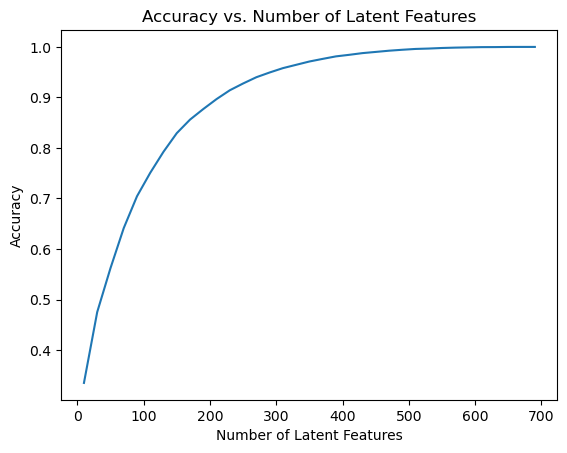

In [39]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [40]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''

    
    # User-item matrix of the training df
    user_item_train = create_user_item_matrix (df_train)
    
    # User-item matrix of the testting df
    user_item_test = create_user_item_matrix (df_test)

    # Find users both in test and in train
    train_idx = set(user_item_train.index)
    test_idx = set(user_item_test.index)
    common_idx = train_idx.intersection(test_idx)
    
    # Find articles both in test and in train
    train_arts = set(user_item_train.columns)
    test_arts = set(user_item_test.columns)
    common_cols = train_arts.intersection(test_arts)


    user_item_test = user_item_test.loc[common_idx, common_cols]
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [41]:
# How many users can we make predictions for in the test set?
user_item_test.shape[0]

20

In [42]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
len(test_idx) - user_item_test.shape[0]

662

In [43]:
# How many articles can we make predictions for in the test set?
user_item_test.shape[1]

574

In [44]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
len(test_arts) - user_item_test.shape[1] 

0

In [45]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c , 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?':d,
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [46]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False )
print (s_train.shape, u_train.shape, vt_train.shape, user_item_matrix.shape)

(714,) (4487, 714) (714, 714) (5149, 714)


In [47]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [48]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

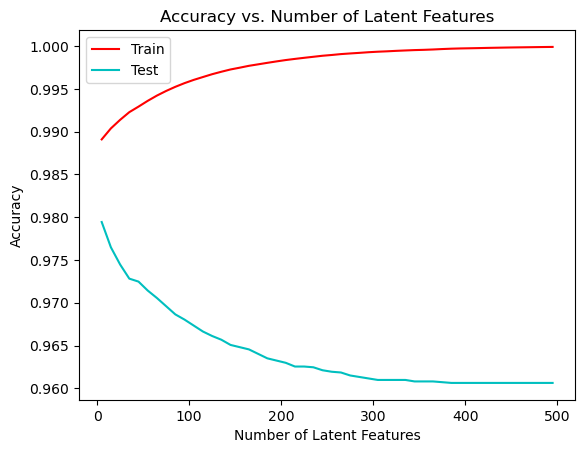

In [49]:
row_idxs = user_item_train.index.isin(test_idx)
col_idxs = user_item_train.columns.isin(test_arts)
u_test = u_train[row_idxs, :]
vt_test = vt_train[:, col_idxs]

#num_latent_feats = np.arange(0, 700+10, 20)
num_latent_feats = np.arange(5, 500, 10)
sum_errs_train = []
sum_errs_test = []
#all_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_estimate = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_estimate = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    #all_errs.append(1 - ((np.sum(user_item_test_estimate)+np.sum(np.sum(user_item_test)))/(user_item_test.shape[0]*user_item_test.shape[1])))
    
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_estimate)
    diffs_test = np.subtract(user_item_test, user_item_test_estimate)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_test.shape[1]), label='Train', color='r');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test.shape[0]*user_item_test.shape[1]), label='Test', color='c');
#plt.plot(num_latent_feats, all_errs, label='All Data')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.savefig('Accuracy vs. Number of Latent Features.png')
plt.show();

In [50]:
def explained_variance(sigma, n_components):
    """
    Computes explained variance number of components
    """
    # percentage of variance explained
    total_var = np.sum(sigma**2)
    var_exp = np.sum([np.square(i) for i in sigma[:n_components]])
    perc_exp = (var_exp / total_var) * 100
    return round(perc_exp, 4)

explained_variance(s_train, 300)

92.0776

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**1. The accuracy reaches around 100% when the number of latent features is at approximately 300. In generaly, the accuracy of training data is above 99%, and it increases while the number of latent features expands, which indicates overfitting in training dataset.** <br>

**2. On. the contrary, the accuracy of test data reduces during the enlarging quantity of latent features. The accuracy maintains at around 96% when the latent features is more than 300.** <br>

**3. At first glance, the level of accuracy is quite promising; however, the classes in the dataset is quite imbalance, and there are only 20 users in the testing dataset. Thus, the result of prediction would be biased.** <br>

**4. When the number of latent features is set as 300, 92.0776% of variance is explained in this model.**

**5. In addition, there are several methods could be considered regarding to the improvement of the recommendation system:** <br>
> **a. A simple feedback could be used as a straight rating system. For instance, a variable could be used by "Like" or "Dislike" after the article is read. Such binary response would be helpful to identify whether the articles cater to users' preferences.** <br>

> **b. The instant interactions among users and articles could be an online measurement of performance. If the interactions increased after a article is released, it would indicate the recommendation and satisfacetion is improved.** <br>

> **c. A/B testing would also be performed. The data could be analyed whether the results supports our hypothesis. Further experiment could be conducted to determine if a certain of new recommendations lead to any significant improvement of interactions.**<br>


<a id='conclusions'></a>

## Conclusion

> **An obvious trend can be observed that the accuracy related to the training data tends to increase when the latent features rises. On the other hand, the accuracy associated with the test data reveals the opposite movement. The difference would be due to the lack of users shared in training and testing data, since only 20 users are found in the test data, which would be insufficient to lead a solid result of estimation to actual values.**<br>

> **It's hard to jump into conclusion that SVD is a reliable recommendation engine in this project. Clearly, the dataset is quite limited. Compared to rating-type system, binary oriented (with 1s and 0s) dataset is more likely to demonstrate imbalanced interactions among users and items (such as articles in this case). Additional recommendation agorithems could be applied. Moreover, there are few possible experiments could improve the recommendation system. For example, online measurement of performance monitoring interactions among users and articles; or observe whether the data analysis supports the hypothesis in the A/B testing.**



In [51]:
#pip freeze > requirements.txt

In [52]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

Traceback (most recent call last):
  File "//anaconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "//anaconda3/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "//anaconda3/lib/python3.10/site-packages/nbconvert/__main__.py", line 3, in <module>
    main()
  File "//anaconda3/lib/python3.10/site-packages/jupyter_core/application.py", line 277, in launch_instance
    return super().launch_instance(argv=argv, **kwargs)
  File "//anaconda3/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "//anaconda3/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 423, in start
    self.convert_notebooks()
  File "//anaconda3/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 585, in convert_notebooks
    raise ValueError(
ValueError: Please specify an output format with '--to <format>'.
The following formats are 

1